# Annihilation Strain Function and Plot

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/bosonSR_repo`


In [2]:
using DelimitedFiles, CairoMakie

In [6]:
include("Annihilation.jl")

h_pcr_ann (generic function with 1 method)

In [5]:
# import SpecialFunctions: expinti



# using SpecialFunctions, Test

# """
#     expinti(z::Complex)

# Exponential integral expinti(z) for complex argument z, matching Python's mpmath.ei(z)
# """
# function expinti(z::Complex)
#     E1 = expint(1, -z)
#     if imag(z) > 0
#         return -E1 + im * π
#     elseif imag(z) < 0
#         return -E1 - im * π
#     else
#         # z real: approach from above
#         return -E1
#     end
# end

# z = 1 + 2im;

# @test isapprox(expinti(z), 1.0421677081649356 + im * 3.7015014259378742)


Test Passed

Omega_a = 9.606051411115763e7 HzMax Omega = 1.0e-8

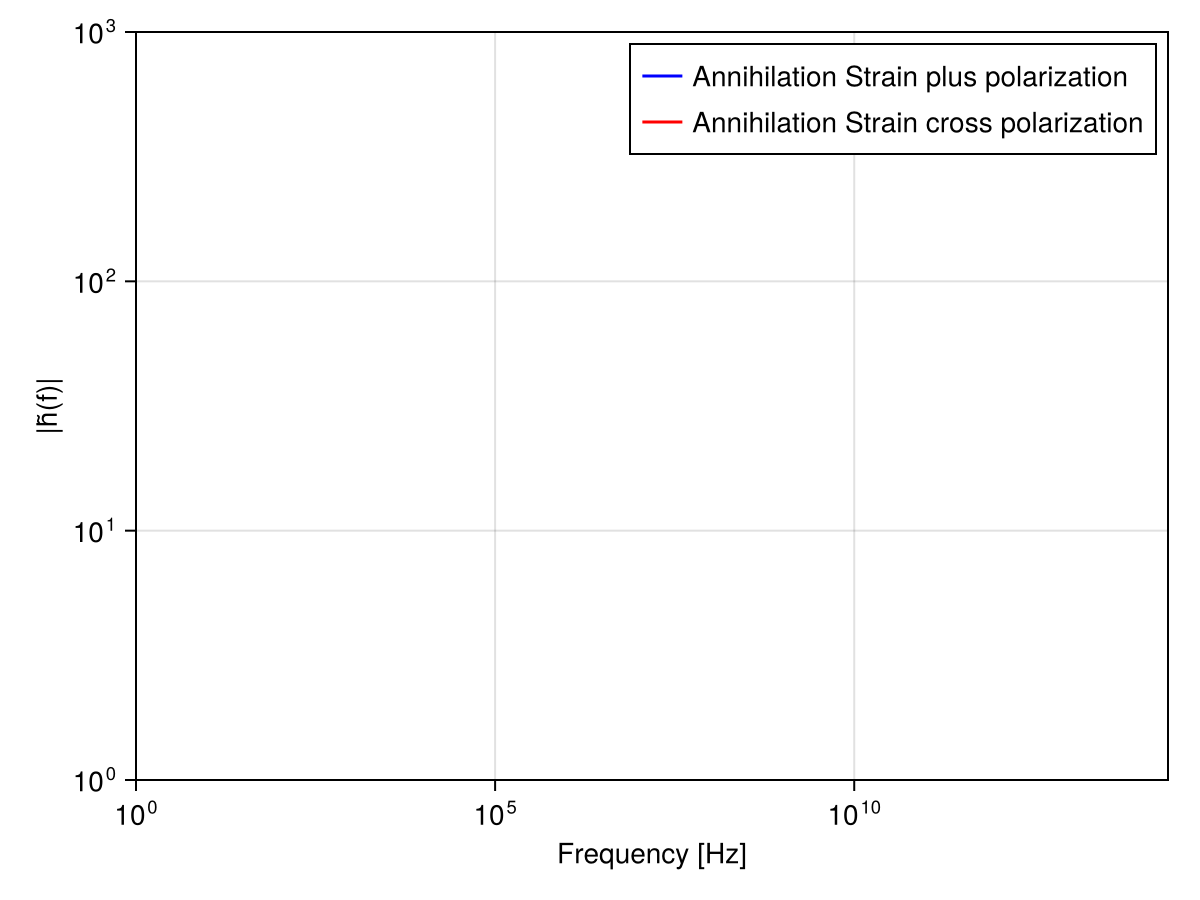

In [11]:
# Plot label params
title_fs = 20
label_fs = 20
tick_fs = 20
legend_fs = 15

# Relevant conversions
M_sun = 2e30 * 5.61e26 # Solar mass -> GeV

# Dependent Params
M_ann_ = 3.1e-04  # in solar masses
mua_ann = 2e-16  # in GeV
alpha_ann = G * M_ann * mua_ann * M_sun
r_kpc = 1
n = 4
m = l = n - 1
phase = 0 
iota = 0 

# call functions
omega = 10 .^ range(-13, -8, length=10000) # in Hz

# ann_strain_result, frequency = h_ann(omega, M_ann_, n, l, alpha_ann, r_kpc)
# ann_strain_abs = abs.(ann_strain_result)
ann_strain_plus, ann_strain_cross,frequency = h_pcr_ann(omega, mua_ann, M_ann_,n,l, alpha_ann, r_kpc, iota, phase )

# Plot
fig = Figure()
ax = Axis(fig[1, 1],
    # title="Annihilation Gravitational Wave Strain",
    # xlabel="Δ Frequency [Hz]",
    # ylabel="|h̃₊(f)|",
    xscale=log10,
    yscale=log10,
    # grid=true,
    # titlefontsize=title_fs,
    # guidefontsize=label_fs,
    # tickfontsize=tick_fs
)
lines!(ax, frequency, abs.(ann_strain_plus), color=:blue, label="Annihilation Strain plus polarization")
lines!(ax, frequency, abs.(ann_strain_cross), color=:red, label="Annihilation Strain cross polarization")
axislegend(ax, position = :rt, fontsize=legend_fs)
ax.xlabel = "Frequency [Hz]"
ax.ylabel = "|h̃(f)|"
fig

In [5]:
# readtxt
data_py = readdlm("check_py_jl/annihilation_strain_py.txt", Float64, skipstart=1)
frequency_py = data_py[:, 1]
ann_strain_abs_py = data_py[:, 2];

isapprox(frequency, frequency_py; rtol=1e-10) || error("Frequencies do not match!")
isapprox(ann_strain_abs, ann_strain_abs_py; rtol=1e-8) || error("Strain values do not match!")

true

# Binary Merger Template and Plot
check this code with Henry

In [111]:
function htilde_plus(
    f,                     # array-like (Hz in your chosen units)
    Msun, r, alpha,        # source mass (Solar mass), distance (kpc), fine-structure parameter,  
    q,                     # binary mass ratio (companion/host)
    m_i, m_f,              # initial/final magnetic quantum numbers (e.g., 1 -> -1)
    eta;                   # parameter entering z (or leave None to use z_scaling below)
    use_z_scaling=false,   # if True, use Eq. (15.5) instead of z=η²/(|Δm|γ)
    relativistic=false
)

    # Horizon Angular velocity function, takes spin param a* and r_plus spin horizon radius. Units are in inverse GeV
    function Omega_plus(a, r)
        return a / (2 * r)
    end

    # Omega needs to be in units of GeV. Since mass is only thing dimensional, 
    # need to add a factor of G into denominator ( [1/(M*G)] = GeV )
    function Omega0_hyp(M, m_i, alpha, n, l)
        numerator = 64 * m_i * alpha^7
        denominator = G*M * n^3 * (2^l) * (2*l + 1) * (2*l + 2) * (m_i^2 + 4 * alpha^2)
        return numerator / denominator
    end

    # Kerr spin horizon radius, takes Mass in GeV, and dimensionless spin
    function r_plus(M, a)
        return M * (1 + sqrt(1 - a^2)) * G
    end
    
    # Superradiant rate
    function super_gamma(n, l, m, omega, mu, M, r, a)

        function glm(a, m, l, r, omega)
            g = 1
            if l == 1
                g *= l^2 * (1 - a^2) + (a * m - 2 * r * omega)^2
            end
            if l != 1
                for k in 1:(l-1)
                    g *= k^2 * (1 - a^2) + (a * m - 2 * r * omega)^2
                end
            end
            return g
        end

        C = (
            2^(4 * l - 1) * factorial(n + l)
            / (n^(2 * l + 4) * factorial(n - l - 1))
            * (factorial(l) / (factorial(2 * l) * factorial(2 * l + 1)))^2
        )
        g = glm(a, m, l, r, omega)
        omega_plus = Omega_plus(a, r)
        gamma_nlm = (
            2 * r / M * C * g * (m * omega_plus - omega) * (G * mu * M)^(4 * l + 5) / G 
        )
        return gamma_nlm
    end

    # takes dimensionless quantum number m_i and alpha
    function a_tilde_crit(m_i, alpha)
        m2 = m_i^2
        return (4.0 * m_i * alpha) / (m2 + 4.0 * alpha^2)
    end

    # all dimensionless
    function q_c(alpha, m_i, a_tilde)
        m = float(m_i)
        one_minus = (1.0 - a_tilde / m)
        # guard small rounding errors inside the sqrt:
        inner = 1.0 - (4.0 * alpha / m * one_minus)^2
        inner = clamp(inner, 0.0, 1.0)

        denom = m^2 * (1.0 - sqrt(inner))^2
        # Avoid divide-by-zero:
        if denom == 0.0
            return 0.0
        end

        return 8.0 * alpha^2 * one_minus / denom
    end

    # M is host BH mass
    # takes mass in GeV, dimensionless q_c, r in GeV is distance from Earth, Omega_0 is angular momentum at BH horizon in GeV
    function h0_from_params(qc, M, r, alpha, Omega0)
        return 24.0 * G*(qc * M / r) * (alpha^(-4)) * (G*M * Omega0)^2
    end

    function gamma_rate(q, M, Omega0)
        return (Omega0^2) * (96.0 / 5.0) * (q / (q + 1.0)^(1.0 / 3.0)) * (M * Omega0)^(5.0 / 3.0)
    end

    function z_parameter(eta, Delta_m, gamma)
        return (eta^2) / (abs(Delta_m) * gamma)
    end

    function z_scaling_211_to_21m1(alpha, q)
        """
        z_{211->21-1} ≈ 7 * (1.81/(1+4 α²))^(1/3) * (q)^(1/3) * (2/(1+q))^(5/3) * (0.45/α)^(11/3)
        """
        return 7.0 * (1.81 / (1.0 + 4.0 * alpha^2))^(1.0 / 3.0) *
                (q^(1.0 / 3.0)) *
                (2.0 / (1.0 + q))^(5.0 / 3.0) *
                (0.45 / alpha)^(11.0 / 3.0)
    end

    function fc_from_Omega0(Omega0)
        return (2.0 / π) * Omega0 * 1e23
    end

    function psi_plus(f, r, f0, Delta_m, gamma)
        return f .* r .+ (f .- f0).^2 ./ (4.0 * abs(Delta_m) * gamma) .- π / 4.0
    end

    # New Function used in the adjusted amplitude from Henry's paper
    function g_func(z)
        z = complex.(z)
        num = exp.(-π * z .+ 2 * z .* atan.(2 * z))
        den = sqrt.(1 .+ 4 * z.^2)
        return num ./ den
    end

    # Relevant constants/conversions
    Mp_local = 1.220890e19
    G_local = 1 / Mp_local^2   
    M_sun = 2e30 * 5.61e26 # Solar mass -> GeV
    r *= 1.6e35 # Kpc -> GeV^-1
    # Convert to natural units
    M = Msun * M_sun # Solar mass -> GeV
    m_boson = alpha / (G_local * M) # Boson mass in GeV

    a = a_tilde_crit(m_i, alpha)
    Omega0 = Omega_plus(a, r_plus(M, a)) / (2.0/π) 
    Omega_binary = Omega0_hyp(M, m_i, alpha, 2, 1)

    println("Omega Binary: ", Omega_binary)
    println("Omega BH: ", Omega0)
    
    # gamma takes BH rotational freq
    if relativistic == false
        Gamma_abs = super_gamma(2, 1, -1, Omega0, m_boson, M, r, a) 
    else
        # Replace with relativistic superradiance rate
        Gamma_abs = 0 
    end

    f = float.(f)
    Delta_m = float(abs(m_f - m_i))
    println("Delta m: ", Delta_m)

    # ã_crit and q_c
    acrit = a_tilde_crit(m_i, alpha)
    qc = q_c(alpha, m_i, acrit)

    # h0 amplitude (15.12)
    h0 = h0_from_params(qc, M, r, alpha, Omega_binary)

    gamma = gamma_rate(q, M, Omega_binary)

    # z (15.1) or scaling (15.5)
    if use_z_scaling
        z = z_scaling_211_to_21m1(alpha, q)
    else
        z = z_parameter(eta, Delta_m, gamma)
    end

    # central frequency and phase (under 15.15)
    f_c = fc_from_Omega0(Omega_binary)
    f0 = f_c
    phase = psi_plus(f, r, f0, Delta_m, gamma)

    # denominator and envelope
    denom = (sqrt(z) / abs(Gamma_abs)) .- 1im * π * (f .- f_c)
    envelope = exp.(-π * z) .* exp.(-2.0 * z * atan.(π * (f .- f0) / abs(Gamma_abs)))

    # Fix: include actual inclination:
    function with_inclination(iota)
        pref = h0 * (1.0 + cos(iota)^2) * sqrt(π) * (Delta_m^2)
        println("Prefix: ", pref)

        return sqrt(G_local) * pref * exp.(1im * phase) .* envelope ./ denom
    end

    println("h0: ", h0)
    println("Envelope: ", envelope[5])
    println("Denominator: ", denom[5])
    println("Phase: ", phase[5])
    println("exp(1im * phase): ", exp.(1im * phase[5]))
    return with_inclination
end

# Given h_+(f) and inclination iota [rad], return h_x(f)
function hcross_from_hplus_freq(hplus_f, iota)
    return 1im * (2*cos(iota)/(1+cos(iota)^2)) * hplus_f
end

hcross_from_hplus_freq (generic function with 1 method)

Omega Binary: 7.121128721301903e-27
Omega BH: 6.260389407306316e-23
Delta m: 2.0
h0: 3.382103682447388e-16
Envelope: 0.9999998696165816
Denominator: 1.8605099655693023e-15 - 0.0052080254133180705im
Phase: 3.3777777777777775e32
exp(1im * phase): 0.398397625284726 - 0.917212806369106im
Prefix: 4.795698156892479e-15


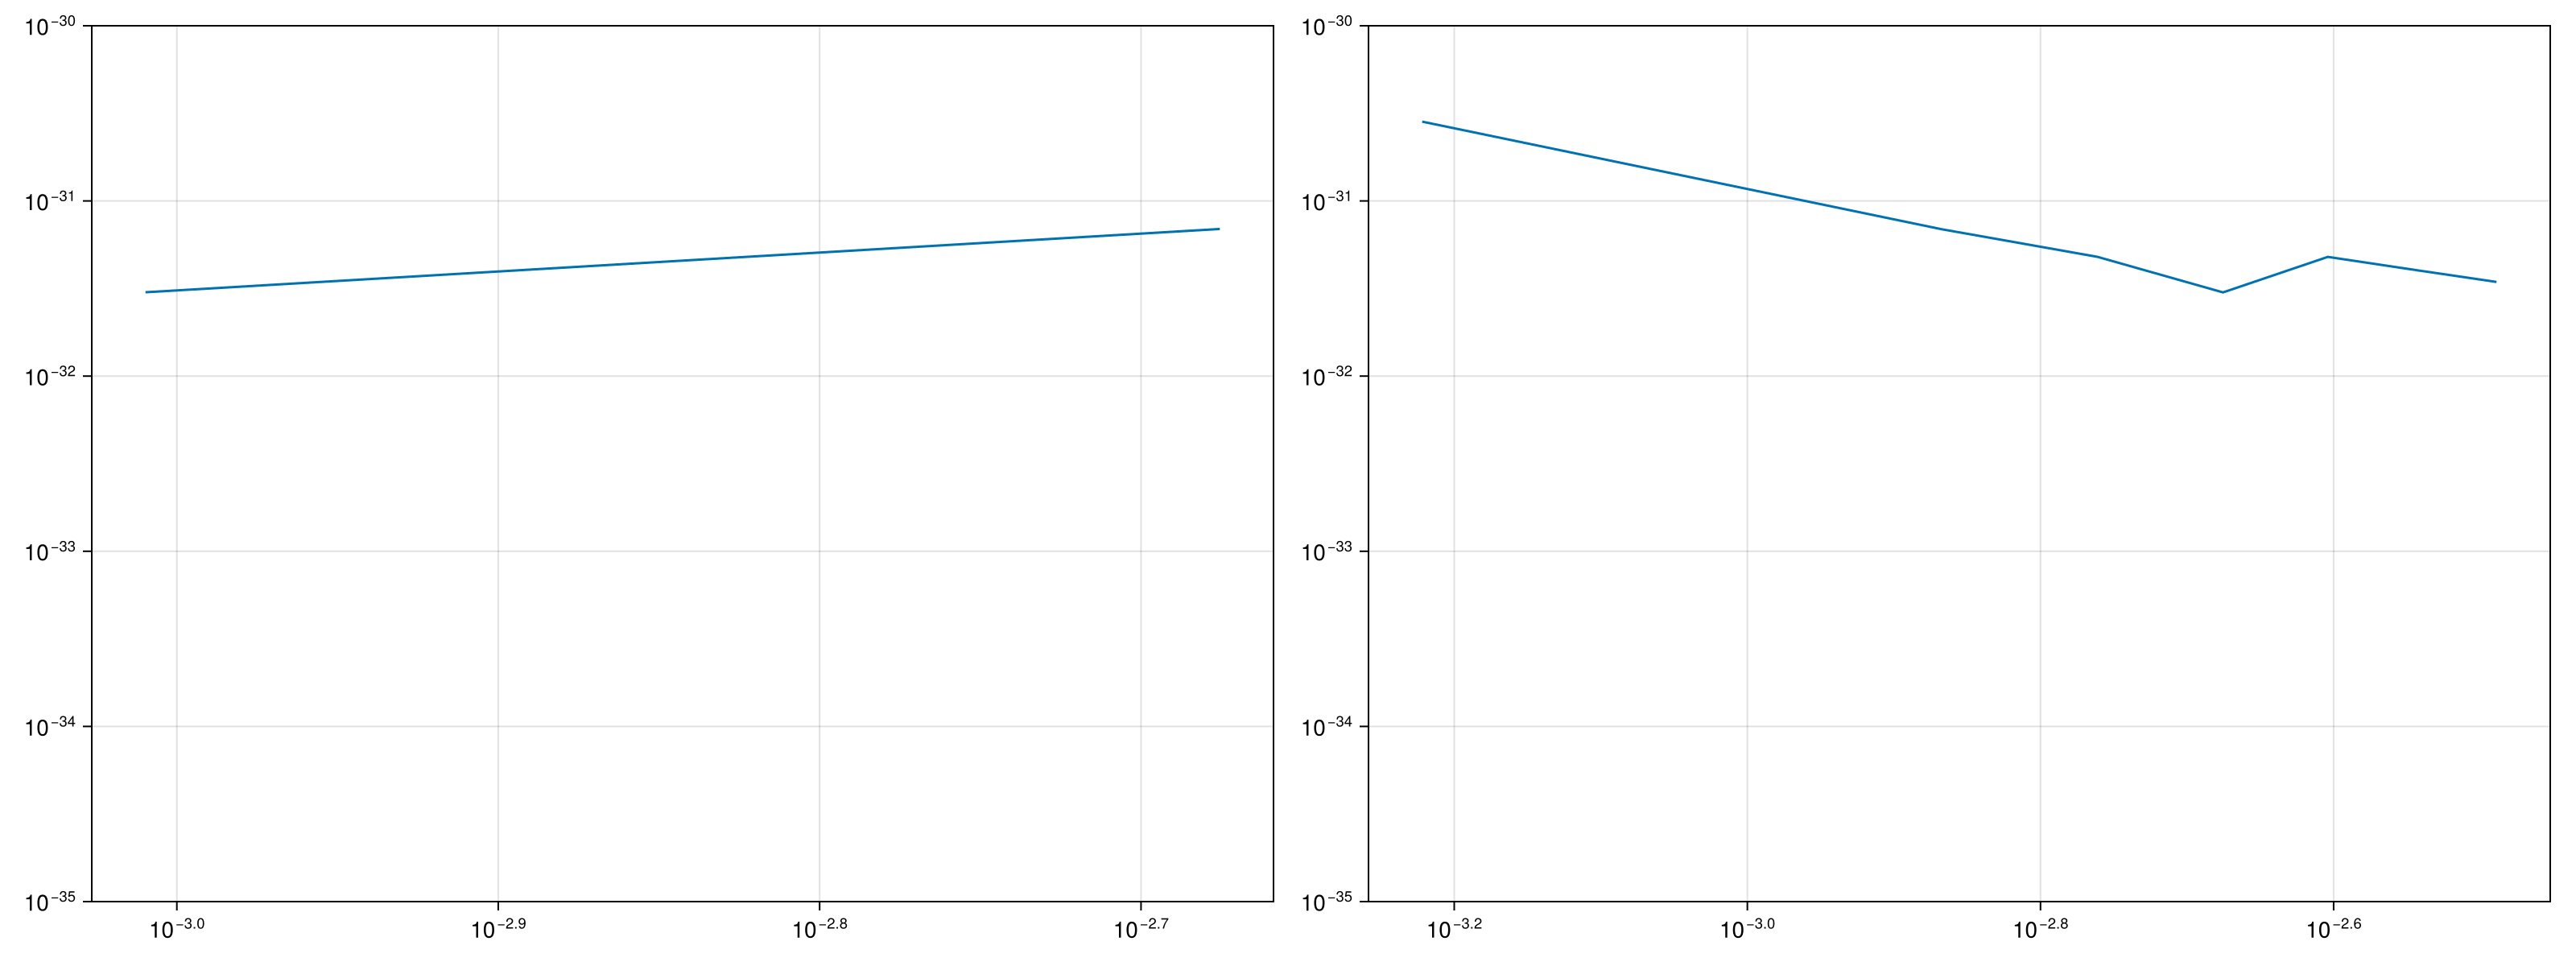

In [112]:
# Relevant Input parameters, units defined
Mp_local = 1.220890e19
G_local = 1 / Mp_local^2

M = 1e3      # BH mass in solar masses
r = 1        # kpc distance away
alpha = 0.3
m_boson_param = alpha/(G_local*M) # Boson mass in GeV
q = 0.1      # Binary mass ratio
m_i = 1
m_f = -1     # Quantum Numbers
eta = 5.0e-2 # parameter entering z (or leave None to use z_scaling below)

# Found for this freq range, can also be estimated using Omega0 function 
f = range(6e-4, 4e-3, length=10)

hplus_of_iota = htilde_plus(f, M, r, alpha, q, m_i, m_f, eta, use_z_scaling=false, relativistic=false)

iota = π  # rad
Hplus = hplus_of_iota(iota)
Hcross = hcross_from_hplus_freq(Hplus, iota)

# --- Plot h+ ---
fig = Figure(size = (1600, 600))
ax1 = Axis(fig[1, 1], yscale=log10, xscale=log10)
lines!(ax1, f[real.(Hplus) .> 0], real.(Hplus)[real.(Hplus) .> 0],
    # xlabel="Frequency f (Hz)",
    # ylabel="|h̃₊(f)|",
    # title="Binary Perturbation — Plus Polarization",
    # xscale=:log10,
    # 
    # grid=true,
    # linewidth=2,
    # size=(800, 600),
    # titlefont=font(title_fs),
    # guidefont=font(label_fs),
    # tickfont=font(tick_fs)
)
ylims!(ax1, 1e-35, 1e-30)

# --- Plot h× ---
ax2 = Axis(fig[1, 2], yscale=log10, xscale=log10)
lines!(ax2, f[real.(Hcross) .> 0], real.(Hcross)[real.(Hcross) .> 0],
    # xlabel="Frequency f (Hz)",
    # ylabel="|h̃ₓ(f)|",
    # title="Binary Perturbation — Cross Polarization",
    # xscale=:log10,
    # yscale=log10,
    # grid=true,
    # linewidth=2,
    # size=(800, 600),
    # titlefont=font(title_fs),
    # guidefont=font(label_fs),
    # tickfont=font(tick_fs)
)
ylims!(ax2, 1e-35, 1e-30)

fig

In [106]:
# Read Python complex data using the custom parser
f_py_plus, Hplus_py = read_python_complex_file("check_py_jl/binary_perturbation_strain_plus_py.txt")
f_py_cross, Hcross_py = read_python_complex_file("check_py_jl/binary_perturbation_strain_cross_py.txt")

println("Successfully read $(length(f_py_plus)) data points for plus polarization")
println("Successfully read $(length(f_py_cross)) data points for cross polarization")

Successfully read 10 data points for plus polarization
Successfully read 10 data points for cross polarization


In [68]:
Hplus_py[1:5], abs.(Hplus_py[1:5])

(ComplexF64[-8.040496920871671e-31 + 2.835063588992475e-31im, -8.501678476036773e-31 - 2.6970917151473267e-32im, 2.133862722732996e-31 + 8.213667661000875e-31im, -7.111565976459405e-31 - 4.5947866254341655e-31im, -2.39723587048461e-31 + 8.100043433270395e-31im], [8.52567746798914e-31, 8.505955557555312e-31, 8.486324679438152e-31, 8.466784204809031e-31, 8.447333510617712e-31])

In [113]:
isapprox( abs.(Hplus_py[1:5]), abs.(Hplus[1:5]), rtol=1e-8)

true

In [110]:
angle.(Hplus_py[1:10])

10-element Vector{Float64}:
  2.802605184667109
 -1.4441713592084946
  2.620136958118546
  2.62864616739432
  2.2381820864637945
  2.246691295739441
  2.255200505015067
 -2.1910626839665177
 -2.182553474690912
 -2.1740442654153114

In [109]:
angle.(Hplus[1:10])

10-element Vector{Float64}:
  2.802605184667109
 -1.4441713592084946
  2.620136958118546
  2.62864616739432
  0.4097691775414066
  2.246691295739441
  2.255200505015067
  2.263709714290681
 -2.182553474690912
 -2.1740442654153114

In [108]:
isapprox(angle.(Hplus_py), angle.(Hplus), rtol=1e-1)

false

In [67]:
Hplus[1:5], abs.(Hplus[1:5])

(ComplexF64[-8.040496920871671e-31 + 2.835063588992475e-31im, 3.994240202707623e-31 - 7.509815254064521e-31im, 2.133862722732996e-31 + 8.213667661000875e-31im, 7.26175554317386e-31 - 4.353543522463893e-31im, -2.39723587048461e-31 + 8.100043433270395e-31im], [8.52567746798914e-31, 8.505955557555306e-31, 8.486324679438152e-31, 8.466784204809026e-31, 8.447333510617712e-31])

In [86]:
@test isapprox(f_py_plus, f; rtol=1e-10)
# @test isapprox(Hplus_py, Hplus; rtol=1e-3)
# @test isapprox(f_py_cross, f; rtol=1e-3)


Test Passed

In [59]:
# Function to parse Python complex number format
function parse_python_complex(s::AbstractString)
    # Remove parentheses and 'j' suffix, replace 'j' with 'im'
    s_clean = replace(string(s), "(" => "", ")" => "", "j" => "im")
    # Handle cases where there's no explicit '+' before imaginary part
    s_clean = replace(s_clean, r"(\d)(-)" => s"\1+\2")
    return parse(ComplexF64, s_clean)
end

# Function to read Python complex data files
function read_python_complex_file(filename::String)
    lines = readlines(filename)
    # Skip header line
    data_lines = lines[2:end]
    
    frequencies = Float64[]
    values = ComplexF64[]
    
    for line in data_lines
        # Split by whitespace, taking first two columns
        parts = split(strip(line))
        if length(parts) >= 2
            # Parse frequency (real part of first complex number)
            freq_str = parts[1]
            freq = parse_python_complex(freq_str)
            push!(frequencies, real(freq))
            
            # Parse complex strain value
            value_str = parts[2]
            value = parse_python_complex(value_str)
            push!(values, value)
        end
    end
    
    return frequencies, values
end

read_python_complex_file (generic function with 1 method)

In [45]:
fig = Figure()
ax = Axis(fig[1, 1], yscale=log10, xscale=log10)
limits!(ax, 1e-1, 1e1, 1e-1, 1e1)
lines!(ax,0:0.1:10, sin.(0:0.1:10), color=:red)
fig

In [ ]:
# SOLUTION 1: Use absolute values
fig1 = Figure(size=(1200, 800))

# Original problematic approach (commented out because it fails)
# ax1 = Axis(fig1[1, 1], yscale=log10, xscale=log10, title="This would fail")
# lines!(ax1, x, y)  # This fails because of zeros and negatives

# Solution 1a: Use absolute values
ax1 = Axis(fig1[1, 1], yscale=log10, xscale=log10, 
           title="Solution 1a: |sin(x)|")
lines!(ax1, x[x .> 0], abs.(y[x .> 0]), color=:red, linewidth=2)

# Solution 1b: Use positive part only + small offset
epsilon = 1e-10
y_positive = max.(abs.(y), epsilon)  # Avoid exact zeros
ax2 = Axis(fig1[1, 2], yscale=log10, xscale=log10, 
           title="Solution 1b: max(|sin(x)|, ε)")
lines!(ax2, x[x .> 0], y_positive[x .> 0], color=:blue, linewidth=2)

# Solution 1c: Filter out problematic values
mask = (x .> 0) .& (y .> 0)  # Only positive x and positive y
ax3 = Axis(fig1[2, 1], yscale=log10, xscale=log10, 
           title="Solution 1c: Filter positive values only")
lines!(ax3, x[mask], y[mask], color=:green, linewidth=2)

# Solution 1d: Use a better function for demonstration
x_good = 10 .^ range(-1, 1, length=1000)  # Already positive x
y_good = x_good.^2 .+ 0.1  # Always positive, good for log-log
ax4 = Axis(fig1[2, 2], yscale=log10, xscale=log10, 
           title="Solution 1d: Better function (x² + 0.1)")
lines!(ax4, x_good, y_good, color=:purple, linewidth=2)

fig1